# Text Tokenization OLID

## Import & Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import matplotlib.cm as cm

from matplotlib.colors import Normalize
from collections import Counter
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

c:\Users\walkervalentinus\Documents\PERKULIAHAN\Final_Year\SEMHAS\tasi2425112-3.8-english\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [ ]:
clean_df = pd.read_csv("dataset-english/Sushil/clean.csv")

## Check Label Distribution (Imbalance Analysis)

In [3]:
# Label count
label_counts = clean_df["labels"].value_counts().sort_index()
labels = label_counts.index
counts = label_counts.values

In [4]:
# Get majority and minority label
major_label = label_counts.idxmax()
minor_label = label_counts.idxmin()

In [5]:
# Count percentage 
total = counts.sum()
diff_percent = ((counts.max() - counts.min()) / total) * 100

In [6]:
plot_df = pd.DataFrame({
    "Label": labels,
    "Count": counts,
    "Category": ["Major" if l == major_label else "Minor" for l in labels]
})

In [7]:
color_map = {"Major": "blue", "Minor": "red"}

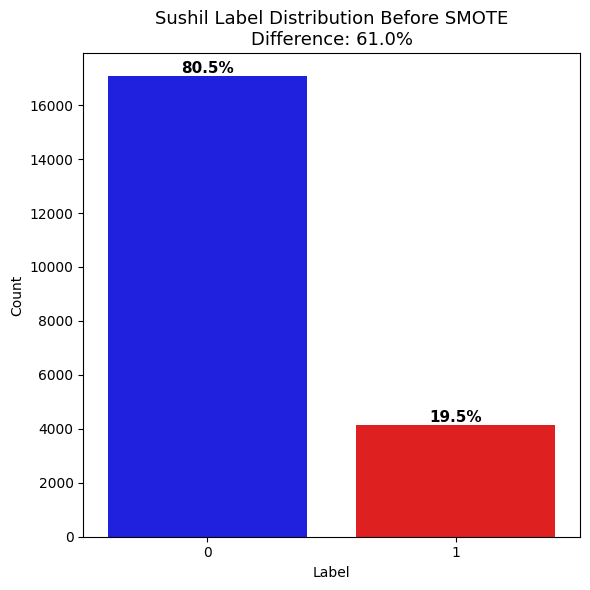

In [8]:
# Plot
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=plot_df, x="Label", y="Count", hue="Category", palette=color_map, dodge=False)
ax.legend_.remove() 

# Add percentage above the bar
for i, count in enumerate(counts):
    pct = (count / total) * 100
    plt.text(i, count + 5, f"{pct:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

# Title and label
plt.title(f"Sushil Label Distribution Before SMOTE\nDifference: {diff_percent:.1f}%", fontsize=13)
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Tokenization

In [9]:
MAX_LEN = 128

# Preprocessing function for tokenization and padding
def preprocessing(df, column1, column2):
    df[column1] = df[column1].fillna('')
    sentences = df[f'{column1}'].values
    labels = df[f'{column2}'].values

    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

    encoded_sentences = []
    for sent in sentences:
        # Tokenizing each sentence
        encoded_sent = tokenizer.encode(
            sent,
            add_special_tokens=True,  # CLS and SEP tokens will be added
            truncation=True,
            max_length=MAX_LEN
        )
        encoded_sentences.append(encoded_sent)

    # Padding sequences to make them of uniform length (this will be done after tokenizing)
    encoded_sentences = pad_sequences(encoded_sentences, maxlen=MAX_LEN, dtype="long",
                                      value=0, truncating="post", padding="post")

    return encoded_sentences, labels

In [10]:
# Function to create attention masks
def attention_masks(encoded_sentences):
    attention_masks = []
    for sent in encoded_sentences:
        # Attention mask, 0 for padding, 1 for actual tokens
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return attention_masks

In [11]:
tokenized_train_we, train_labels_we = preprocessing(clean_df, 'No Stopword Text', 'labels')
tokenized_train_ed, train_labels_ed = preprocessing(clean_df, 'Text with Emoji no Stopword', 'labels')

In [ ]:
X_we = tokenized_train_we
y_we = train_labels_we

X_ed = tokenized_train_ed
y_ed = train_labels_ed

## SMOTE Oversampling

In [ ]:
sm = SMOTE(random_state=42, sampling_strategy='auto')
X_smote_we, y_smote_we = sm.fit_resample(X_we, y_we)
X_smote_ed, y_smote_ed = sm.fit_resample(X_ed, y_ed)

## Check Oversampling Result 

In [14]:
print("\nSushil Label counts after SMOTE:")
print(Counter(y_smote_we))
print(Counter(y_smote_ed))


Sushil Label counts after SMOTE:
Counter({0: 17075, 1: 17075})
Counter({0: 17075, 1: 17075})


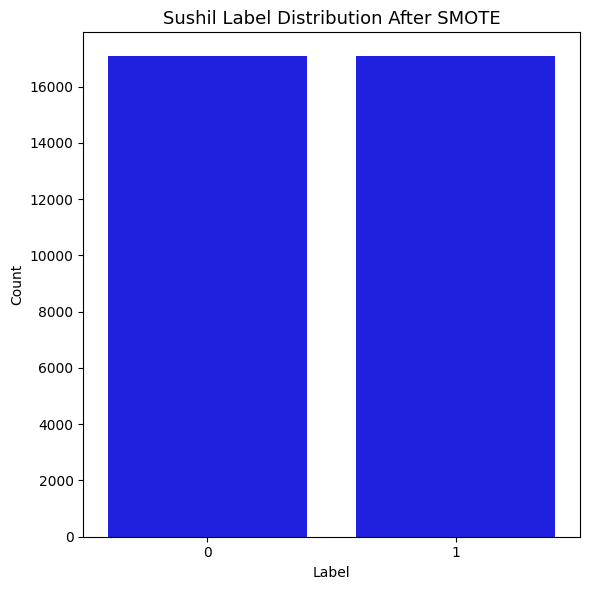

In [15]:
plt.figure(figsize=(6, 6))
sns.barplot(x=list(Counter(y_smote_we).keys()), y=list(Counter(y_smote_we).values()), color='blue')
plt.title("Sushil Label Distribution After SMOTE", fontsize=13)
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Save Result

In [16]:
# Save SMOTE results for "No Stopword Text"
resampled_df_no_emoji = pd.DataFrame(X_smote_we.tolist())
resampled_df_no_emoji['label'] = y_smote_we
resampled_df_no_emoji.to_csv("dataset/Sushil/tokenized_smote_we_mbert.csv", index=False)

In [17]:
# Save SMOTE results for "Text with Emoji no Stopword"
resampled_df_with_emoji = pd.DataFrame(X_smote_ed.tolist())
resampled_df_with_emoji['label'] = y_smote_ed
resampled_df_with_emoji.to_csv("dataset/Sushil/tokenized_smote_ed_mbert.csv", index=False)

## Train Test Split 

In [18]:
def split_and_save(dataframe, output_dir, name_prefix):
    train_df, temp_df = train_test_split(dataframe, test_size=0.2, stratify=dataframe['label'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
    os.makedirs(output_dir, exist_ok=True)
    train_df.to_csv(f"{output_dir}/{name_prefix}_train_mbert.csv", index=False)
    val_df.to_csv(f"{output_dir}/{name_prefix}_val_mbert.csv", index=False)
    test_df.to_csv(f"{output_dir}/{name_prefix}_test_mbert.csv", index=False)

In [19]:
# Load the resampled CSV files
df_no_emoji_mbert = pd.read_csv("dataset/Sushil/tokenized_smote_we_mbert.csv")
df_with_emoji_mbert = pd.read_csv("dataset/Sushil/tokenized_smote_ed_mbert.csv")

In [20]:
# Split and save the data for both datasets
split_and_save(df_no_emoji_mbert, "dataset/Sushil/TTVWE", "no_emoji")
split_and_save(df_with_emoji_mbert, "dataset/Sushil/TTVED", "with_emoji")